In [1]:
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

from langchain_chroma import Chroma

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'income_tax_collection',
    persist_directory = './income_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [2]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str
    
graph_builder = StateGraph(AgentState)

In [3]:
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    docs = retriever.invoke(query)
    return {'context':docs}

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = 'gpt-4o')

In [5]:
from langchain import hub
generate_prompt = hub.pull('rlm/rag-prompt')
generate_llm = ChatOpenAI(model = 'gpt-4o', max_completion_tokens=100)

def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = generate_prompt | generate_llm
    response = rag_chain.invoke({'question': query , 'context': context})
    return {'answer':response.content} # AImessage 부분을 포함시키 않기 위함

In [6]:
# END 로 끝내야함
from typing import Literal
relevance_doc_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['relevant','irrelevant']:
    query = state['query']
    context = state['context']
    # print(f'context == {context}')
    
    doc_relevance_chain = relevance_doc_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    # print(f'doc relevance response : {response}')
    if response['Score']==1:
        return 'relevant'
    
    return 'irrelevant'

In [7]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ['사람과 관련된 표현 -> 거주자']
rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
사전: {dictionary}
질문: {{query}}                             
""")

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({'query':query})
    return {'query' : response}

In [8]:
# from langchain import hub
# hallucination_prompt = hub.pull("langchain-ai/rag-answer-hallucination")

from langchain_core.prompts import PromptTemplate
hallucination_prompt = PromptTemplate.from_template("""
You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
Given documents, which are excerpts from income tax law, and a student's answer;
If the student's answer is based on documents, respond with "not hallucinated",
If the student's answer is not based on documents, respond with "hallucinated".

documents: {documents}
student_answer: {student_answer}
""")

hallucination_llm = ChatOpenAI(model='gpt-4o', temperature=0)

def check_hallucination(state: AgentState) -> Literal["hallucinated", "not hallucinated"]:
    answer = state['answer']
    context = state['context']
    context = [doc.page_content for doc in context]
    hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    # hallucination_chain = hallucination_prompt | hallucination_llm 
    response = hallucination_chain.invoke({'student_answer': answer, 'documents': context})

    return response

In [9]:
from langchain import hub
helpfulness_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def check_helpfulness_grader(state:AgentState) -> Literal["helpful","unhelpful"]:
    query = state['answer']
    answer = state['answer']
    # hallucination_chain = hallucination_prompt | hallucination_llm | StrOutputParser()
    helpfulness_chain = helpfulness_prompt | llm 
    response = helpfulness_chain.invoke({'student_answer': answer, 'question': query})
    if response['Score']==1:
        return 'helpful'
    return 'unhelpful'

def check_helpfulness(state: AgentState):
    return state

In [10]:
# query = '연봉 5천만원인 거주자의 소득세는 얼마인가요?'
# context = retriever.invoke(query)

# generate_state = {'query':query, 'context':context}
# answer = generate(generate_state)

# # hallucination_stete = {'answer':answer, 'context': context}
# # check_hallucination(hallucination_stete)

# helpfulness_state = {'query':query, 'answer':answer}
# check_helpfulness(helpfulness_state)

In [11]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
# graph_builder.add_node('check_doc_relevance', check_doc_relevance)
graph_builder.add_node('rewrite', rewrite)
# graph_builder.add_node('check_hallucination', check_hallucination)
graph_builder.add_node('check_helpfulness', check_helpfulness)

In [12]:
from langgraph.graph import START, END

graph_builder.add_edge(START , 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant' : 'generate',
        'irrelevant': END
    }
)
graph_builder.add_conditional_edges(
    'generate',
    check_hallucination,
    {
        'hallucinated' : 'generate',
        'not hallucinated': 'check_helpfulness'
    }
)

graph_builder.add_conditional_edges(
    'check_helpfulness',
    check_helpfulness_grader,
    {
        'helpful' : END,
        'unhelpful': 'rewrite'
    }
)

graph_builder.add_edge('rewrite', 'retrieve')


In [13]:
graph = graph_builder.compile()

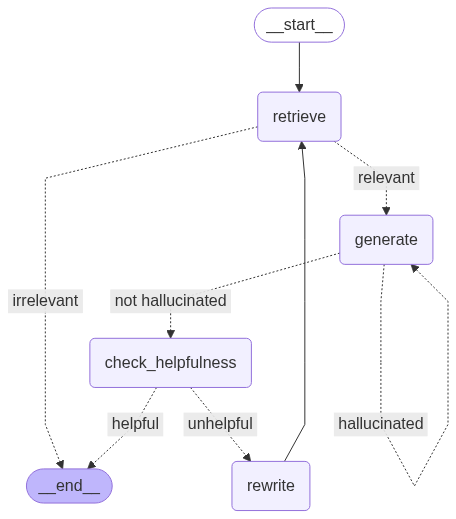

In [14]:
graph

In [15]:
initial_state = {'query' : '배가 고파요'}
graph.invoke(initial_state)

{'query': '배가 고파요',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='기부자의 인적사항 등을 기부자와 다르게 적 발급하는 등 가액의 경우: 기부금영수증의 적립 금액의 100분의  \n\n1   \n② 상속세 및 증여세법, 제160조제13항에 따라 보고 및 제철물을 이해하이 아니라는 것 제정제2조에 따라 출연연면 내의 실제에 대한 정부의 사항과 비슷하이므로 이해하여 자산자이 부과되는 경우에는 제1항제각 사항에 적용하니 아니하다.  \n제1항에 따른 가산세는 종합소득세법에 없는 경우에도 적용한다.\n[본조신설 2019. 12. 31.]\n제8조의8(사업자등록신고 · 사용 불성실 가산세)\n① 사업자가 다음 각 호의 어느 하나에 해당하는 경우에는 다음 각 호의 부분에 따라 금액을 가산세로 하여 과세기간의 종합소득 결정에 대해 남부하여야 한다. \n1. 제160조의5제1항 각 호의 어느 하나에 해당하는 경우로 사업계좌를 사용하지 않는 경우: 사업업제처를 사용하이 아니라 금액의 1 접근──────────────────────────────────────────────────────────────────────────────────────────────\n\n제160조의5제3항에 따라 사업용계좌를 신고하지 아니한 경우(사업장별 신고를 하지 아니하고 이미 신고한 다른 사업장의 사업용계좌를 사용하는 경우)는 제1항한다. 다음 각 목의 금액 중 큰 금액\n\n가. 다음 계산식에 따라 계산한 금액\nA: 해당 과세기간의 수입금액\nB: 미신고계좌(과세기간)으로 사업용계좌를 신고하지 아니한 기간으로 신고한 다음 날부터 신고 전 본까지의 입수를 합한 금액, 미신고기간이 2개 이상 과세기간인 결제 있으면 각 과세기간별로 미신고계좌는 적용함\nC: 365(윤년에는 366으로 한다)\n나. 제160조의5제1항 각 호의 해당 거래금액의 합계액의 1천분의 2\n(1) 제

In [16]:
initial_state = {'query' : '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?'}
graph.invoke(initial_state)

{'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './documents/income_tax.txt'}, page_content='② 제70조제1항, 제70조의2에 따른 제74조에 따라 차례로 할 것이 제70조제1항제2호에 따르며 서류를 제출하여야 한다는 경우에는 기준소득 중 거주자 본인이 된다(분산)과 제70조제2와 제74조에 따른 제료 및 제대법을 포함한다. 단, 차별제표청정인 그 업체를 남겨 제출한 경우로 그에 대하여 아니하다.<개정 2013. 1. 1.>\n  ③ 제80조에 따른 수익과 관련의 경우에는 기초공제 중 거주자 본인이 된다(분산)과 그에 관한 적지사항을 분명히 한다.\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제54조의2(공동사업에 대한 소득공제 등 특례) 제51조의3 또는 「조세특례제한법」에 따른 소득공제를 적용하거나 제59조의2에 따른 세액감면을 적용하는 경우 제54조제3항에 따라 공동사업자의 소득에 합산과세되는 특별세액거래의 지출․납입․투자 등의 금액이 있을 경우 주된 공동사업자의 소득에 합산과세되는 소득금액에 합산되어 주된 공동사업자의 합산과세세액은 공동사업소득액 또는 공동사업창출세액을 계산할 때 소득공제 또는 세액공제를 받을 수 있다. \n[개정 2014. 1. 1.]\n[전문개정 2009. 12. 31.]\n[제목개정 2014. 1. 1.]\n제2절 세액의 계산 <개정 2009. 12. 31.>\n제1관 세율 <개정 2009. 12. 31.>\n제55조(세율) 거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 "종합소득과세표준세액"이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n종합소득\n┌─────────────